In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the dataset
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset has 284807 rows and 31 columns.


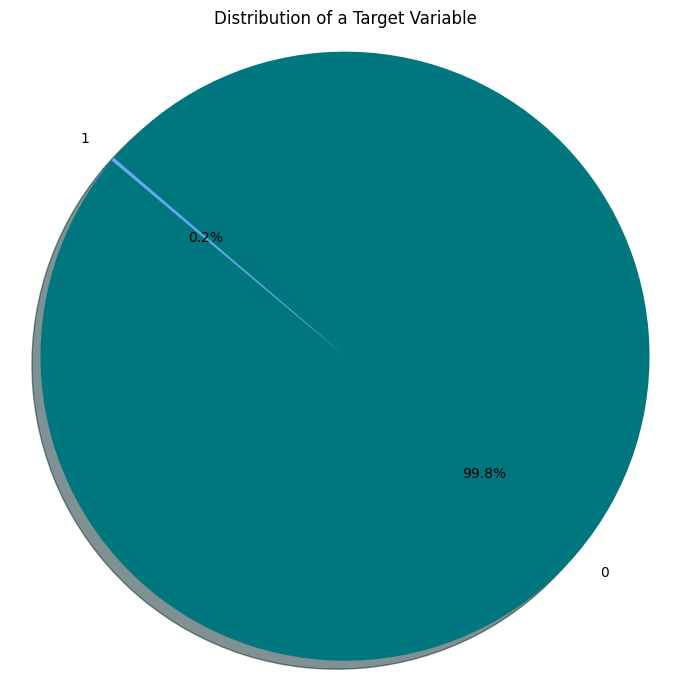

In [2]:
# Distribution of the target variable (fraud detection)
status_counts = df.Class.value_counts()

# Create the pie chart
palette = ['#00777F', '#5BABF5', '#AADEFE', '#EAAC9F', '#8AA0AF']
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=palette, shadow=True)
plt.title('Distribution of a Target Variable')
plt.axis('equal')
plt.tight_layout()
plt.show()

D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Isolation Forest Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.85      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9015054619225298


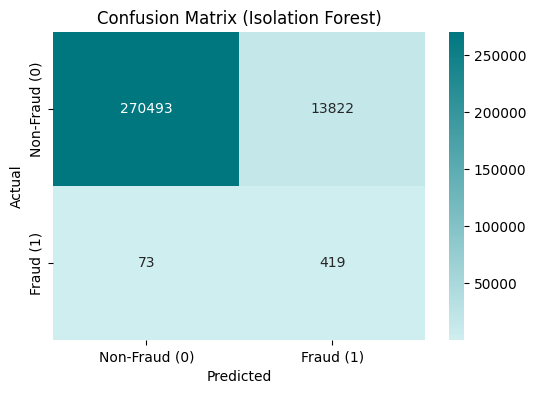

In [3]:
# Feature names
features = df.columns[:-1]  # Excluding the target column

# Transforming skewed data
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values



# --- Isolation Forest (sklearn) ---
iso_forest = IsolationForest(contamination=0.05, random_state=101)
iso_preds = iso_forest.fit_predict(X_scaled)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

print("Isolation Forest Evaluation:")
print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

# Confusion Matrix
cm = confusion_matrix(y, iso_preds)
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#CFEEF0', '#00777F'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')
plt.title('Confusion Matrix (Isolation Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [16]:
# --- Autoencoder for Anomaly Detection (PyTorch) ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        
        # Latent space
        self.latent = nn.Linear(8, 4)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)

In [17]:
print(input_dim)

30


Epoch [10/50], Loss: 1.0040
Epoch [20/50], Loss: 1.0028
Epoch [30/50], Loss: 1.0018
Epoch [40/50], Loss: 1.0009
Epoch [50/50], Loss: 1.0000
Autoencoder Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    284315
           1       0.02      0.90      0.03       492

    accuracy                           0.90    284807
   macro avg       0.51      0.90      0.49    284807
weighted avg       1.00      0.90      0.95    284807

ROC AUC Score:  0.9019132849471752


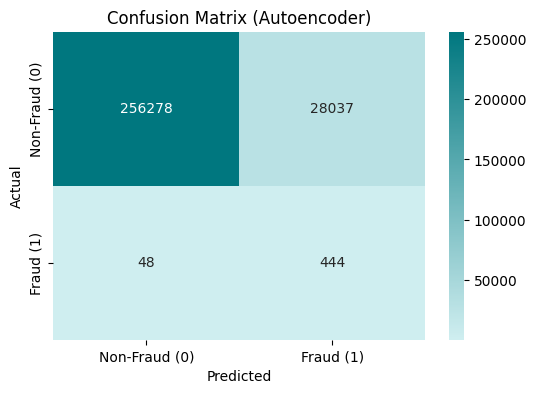

In [18]:
# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
df_transformed = df.copy()
# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    reconstructed = autoencoder(X_train)
    loss = criterion(reconstructed, X_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
reconstructed = autoencoder(X_scaled_tensor)
mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

# Autoencoder evaluation
print("Autoencoder Evaluation:")
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)

# Confusion Matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')
plt.title('Confusion Matrix (Autoencoder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()